In [2]:
# -*- coding: utf-8 -*-
import os 
import itertools
from __future__ import division
import numpy as np
from numpy import linalg
from numpy.random import *
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [3]:
#os.mkdir("plot")
os.listdir(os.getcwd())

['.ipynb_checkpoints', 'plot', 'test_02-05-2015.ipynb']

In [641]:
def funk_pareto(beta,n,m,plot_boolean=False):
    # Génère un échantillon selon les paramètres
    # indiqués  (affiche un graphe)
    # beta : float, n: integer, m: integer
    s = np.random.pareto(beta, n) + m
    lena = np.arange(0,50)
    if(plot_boolean == True):
        plt.figure()
        count, bins, ignored = plt.hist(s, 100, range=[1, 5], normed=True)
        fit = beta*m**beta/bins**(beta+1)
        plt.plot(bins, max(count)*fit/max(fit),linewidth=2, color='r')
        plt.title(" Densite de Pareto, beta = " + str(beta)+", n ="+str(n),fontsize=16)
        plt.savefig("plot\\Pareto_dist"+"_n="+str(n)+"_beta="+str(beta))
        plt.show()
    return(s)

def funk_empirical_mean(ech):
    # Calcule la moyenne empirique d'une echantillon
    #ech : list of floats
    return(np.sum(ech)/len(ech))

def funk_empirical_variance(ech):
    # Calcule la variance empirique d'un échantillon
    #ech : list of floats
    res = np.sum((ech - funk_empirical_mean(ech))**2)/len(ech)
    return(res)

def funk_sample(ech,m, rep = True):
    # Fonction réalisant un sampling
    # ech : array of float, m : int, rep : Boolean
    return(np.random.choice(ech, m, replace=rep))


def funk_bootstrap_naive(ech,B,estimateur,rep=True):
    # Donne la version bootstrap_naive d'un estimateur
    # ech : array of floats, B: int, m: int , rep : Boolean,
    # estimateur: functional
    l=[]
    m = len(ech)
    for esc in range(1,B): # B = 10
        l.append(funk_sample(ech, m, rep)) #m = 5, n = 100
    res = np.sum([estimateur(x) for x in l])/B
    return(res)

def funk_asymptot_naiv(beta,seuil,B,n,plot_call=True,vec_call = True):
    # Réalise les estimations de la moyenne  et de la variance avec bootstrap
    # beta : float, seuil: float, B: int , n: int
    # plot_call : Boolean, vec_call : Boolean
    l_emp , v_emp , l_boot , v_boot = [],[],[],[]
    for esc in range(B,n):
        ech = funk_pareto(beta,n,seuil)
        l_emp.append(funk_empirical_mean(ech))
        v_emp.append(funk_empirical_variance(ech))
        l_boot.append(funk_bootstrap_naive(ech,B,funk_empirical_mean))
        v_boot.append(funk_bootstrap_naive(ech,B,funk_empirical_variance))
    if((plot_call == True) ):
        f, axarr = plt.subplots(2, 2)
        axarr[0, 0].hist(l_emp)
        axarr[0, 0].set_title('Empirical Mean')
        axarr[0, 1].hist(v_emp)
        axarr[0, 1].set_title('Empirical Var')
        axarr[1, 0].hist(l_boot)
        axarr[1, 0].set_title('Boot mean')
        axarr[1, 1].hist(v_boot)
        axarr[1, 1].set_title('Boot Var')
        plt.tight_layout()
    if(vec_call == True):
        return([l_emp,v_emp,l_boot,v_boot])
    
def funk_boot_strap_dist(ech,thresh,B,estimateur,plot_call=False):
    # génére une prob  et outil pour la fonction de répartition
    # ech : array of float, thresh : float, B : int
    l=[]
    m = len(ech)
    mean_emp = funk_empirical_mean(ech)
    for esc in range(B):
        l.append(estimateur(funk_sample(ech,m,len(ech))))
    res = np.sum([1 if (np.sqrt(m)*(x - mean_emp) < thresh) else 0 for x in l])/B
    if(plot_call == True):
        thresh = np.linspace(-1, 1, num=100)
        plt.figure()
        plt.plot(thresh,[funk_boot_strap_dist(ech,x,B,estimateur) for x in thresh])
        plt.title(" Fonction de repartition bootstrap ")
        plt.ylim(0,1.2)
        plt.xlim(min(thresh)-0.1,max(thresh)+0.1)
        plt.show()
    return(res)

def funk_denomb(n,m):
    # Calcule le nombre "m parmi n"
    # m: int, n : int
    fact = lambda z : reduce(lambda x,y:x*y,range(1,z+1),1)
    return(fact(n)/(fact(m)*fact(n-m)))

def funk_bootstrap_outof(ech,m,estimateur):
    # Fonction bootstrapant "m out of n" pour un estimateur
    #ech : array of float, m: int
    n = len(ech)
    thresh = funk_denomb(n,m)
    if(thresh< 5000000):
        s = set(ech)
        test = map(list, itertools.combinations(s, m))
        return(np.sum([estimateur(x) for x in test])/len(test))        
    else:
        print("Denombrement trop large")

def funk_bootstrap_outof_dist(ech,m,estimateur,xi,plot_call = False):
    # Fonction bootstrapant "m out of n" pour un estimateur
    # ech : array of float, m: int , estimateur : function, xi :float
    # plot_call : Boolean
    n = len(ech)
    thresh = funk_denomb(n,m)
    emp_estimateur =estimateur(ech)
    if(thresh< 3000000):
        s = set(ech)
        test = map(list, itertools.combinations(s, m))
        test = [np.sqrt(m)*(estimateur(x)-emp_estimateur) for x in test]
        test = np.sum([1 if (x < xi) else 0 for x in test])/len(test)
        if(plot_call == True):
            thresh = np.linspace(-.1, 0.3, num=100)
            plt.figure()
            plt.plot(thresh,[funk_bootstrap_outof_dit(ech,m,estimateur,x) for x in thresh])
            plt.title(" Fonction de repartition bootstrap m_outof_n")
            plt.ylim(0,1.2)
            plt.xlim(min(thresh)-0.1,max(thresh)+0.1)
            plt.show()

        return(test)
    else:
        print("Denombrement trop large")
        
def funk_boot_strap_dist_normalized(ech,thresh,estimateur,B,plot_call=False):
    # génére une prob  et outil pour la fonction de répartition
    # Version normalisée
    # ech : array of float, thresh : float, B : int, estimateur : function
    # plot_call : Boolean
    l=[]
    l_v=[]
    m = len(ech)
    mean_emp = estimateur(ech)
    for esc in range(B):
        tes_pass = funk_sample(ech,m,len(ech))
        l.append(estimateur(tes_pass))
        l_v.append(funk_empirical_variance(tes_pass))
    res = np.sum([1 if (np.sqrt(m)*(l[x] - mean_emp)/np.sqrt(l_v[x]) < thresh) else 0 for x in range(len(l))])/len(l)
    if(plot_call == True):
        thresh = np.linspace(-1, 1, num=100)
        plt.figure()
        plt.plot(thresh,[funk_boot_strap_dist_normalized(ech,x,estimateur,B) for x in thresh])
        plt.title(" Fonction de repartition bootstrap normalized")
        plt.ylim(0,1.2)
        plt.xlim(min(thresh)-0.1,max(thresh)+0.1)
        plt.show()
    return(res)

def funk_bootstrap_outof_dist_normalized(ech,m,estimateur,xi,plot_call = False):
    # Fonction bootstrapant "m out of n" pour un estimateur
    # Version normalisée
    # ech : array of float, m: int, estimateur : function, xi : flot
    # plot_call : Boolean
    n = len(ech)
    thresh = funk_denomb(n,m)
    emp_estimateur =estimateur(ech)
    if(thresh< 3000000):
        s = set(ech)
        test = map(list, itertools.combinations(s, m))
        test = [np.sqrt(m)*(estimateur(test[x])-emp_estimateur)/np.sqrt(funk_empirical_variance(test[x]))
                for x in range(len(test))]
        test = np.sum([1 if (x < xi) else 0 for x in test])/len(test)
        if(plot_call == True):
            thresh = np.linspace(-1, 1, num=100)
            plt.figure()
            plt.plot(thresh,[funk_bootstrap_outof_dist_normalized(ech,m,estimateur,x) for x in thresh])
            plt.title(" Fonction de repartition bootstrap m_outof_n normalized")
            plt.ylim(0,1.2)
            plt.xlim(min(thresh)-0.1,max(thresh)+0.1)
            plt.show()
        return(test)
    else:
        print("Denombrement trop large")
        
def funk_beta_moment(ech,seuil):
    # Méthode des moments pour Beta
    # ech : array of float, seuil : float
    mean = funk_empirical_mean(ech)
    return(mean/(mean-seuil))
def funk_beta_mle(ech,seuil):
    # Méthode MLE pour Beta
    # ech : array of float, seuil : float
    return(len(ech)/np.sum(np.log(([x/seuil for x in ech]))))
def funk_hill_moment(ech,seuil):
    # calcul de l'estimateur de Hill par la méthode des momments
    # ech : array of floats , seuil : float
    return(1/funk_beta_moment(ech,seuil))
def funk_hill_mle(ech,seuil):
    # Méthode MLE pour Hill par la méthode du MLE
    # ech : array of float, seuil : float
    return(1/funk_beta_mle(ech,seuil))
def funk_theta_moment(ech,c,a):
    # calcul le theta moment
    # c: float, a : float, ech : array of string
    res = funk_beta_moment(ech,c)    
    return((c/a)**res)
def funk_theta_mle(ech,c,a):
    # calcul le theta MLE
    # c: float, a : float, ech : array of string
    res = funk_beta_mle(ech,c)    
    return((c/a)**res)

def funk_test_graph_hill(beta, seuil,n, n_mc ,estimateur,a_i, type_name,plot_save=False):
    # Généer les graph de la méthode d'estimation du paramètre de Hill
    # beta : float , seuil : float, estimateur : function, 
    # plot_save : Boolean
    l=[]
    for esc in range(1,n_mc):
        echantillon = funk_pareto(beta,n,seuil)
        l.append(np.sqrt(n)*((estimateur(echantillon,seuil))-(1/beta)))
    l_sig=np.sqrt(np.var(l))
    l_mean=np.mean(l)
    lena = np.arange(-2,2,1/len(l))
    norma = [(1/np.sqrt(2*np.pi*l_sig**2)*np.exp((-1/2)* ((x-l_mean)/l_sig)**2)) for x in lena]
    plt.figure()
    plt.hist(l,normed=True)
    plt.plot(lena,norma,color="r")
    plt.title("Densite de l'erreur Empirique : " + 
              r'$\displaystyle\ \sqrt{n}(\widehat{Hill}_n - Hill)$'+ '\n'+
              'n = '+str(n)+ ', beta = '+ str(beta) + ' , a = '+str(a_i)+'\n'+type_name,fontsize=16)
    #plt.
    if(plot_save==True):
        plt.savefig("plot\\Error_HIll_"+type_name+"_n="+str(n)+
                    "_beta="+str(beta)+"_a="+str(a_i)+".png",bbox_inches="tight")
    plt.show()
    l_theta=[]
    for esc in range(1,n_mc):
        echantillon = funk_pareto(beta,esc,seuil)
        l_theta.append((estimateur(echantillon,seuil)))
    plt.figure()
    plt.plot(l_theta)
    plt.plot(np.repeat(np.mean(l_theta),len(l_theta)),'r')
    plt.title("Convergence de l'estimateur de " +
              r'$\displaystyle\widehat{Hill}_n$'+'\n'+type_name,fontsize=16)
    if(plot_save==True):
        plt.savefig("plot/Convergence_Hill_"+type_name+"_n="+str(n)+"_beta="+str(beta)+
                    "_a="+str(a_i)+".png",bbox_inches="tight")
    plt.show()
def funk_test_graph_theta(beta, seuil,n, n_mc ,estimateur,a_i, type_name,plot_save=False):
    # Généer les graph de la méthode d'estimation du paramètre de theta
    # beta : float , seuil : float, estimateur : function, 
    # plot_save : Boolean
    l=[]
    for esc in range(1,n_mc):
        echantillon = funk_pareto(beta,n,seuil)
        l.append(np.sqrt(n)*((estimateur(echantillon,seuil,a_i))-((seuil/a_i)**beta)))
    l_sig=np.sqrt(np.var(l))
    l_mean=np.mean(l)
    lena = np.arange(-20,35,1/len(l))
    norma = [(1/np.sqrt(2*np.pi*l_sig**2)*np.exp((-1/2)* ((x-l_mean)/l_sig)**2)) for x in lena]
    plt.figure()
    plt.hist(l,normed=True)
    plt.plot(lena,norma,color="r")
    plt.title("Densite de l'erreur Empirique : " + 
              r'$\displaystyle\ \sqrt{n}(\widehat{\theta}_n - \theta)$'+ '\n'+
              'n = '+str(n)+ ', beta = '+ str(beta) + ' , a = '+str(a_i)+'\n'+type_name,fontsize=16)
    if(plot_save==True):
        plt.savefig("plot\\Error_theta"+type_name+"_n="+str(n)+"_beta="+str(beta)+
                    "_a="+str(a_i)+".png",bbox_inches="tight")
    plt.show()
    l_theta=[]
    for esc in range(1,n_mc):
        echantillon = funk_pareto(beta,esc,seuil)
        l_theta.append((estimateur(echantillon,seuil,a_i)))
    plt.figure()
    plt.plot(l_theta[0:100])
    plt.plot(np.repeat(np.mean(l_theta),100),'r')
    plt.title("Convergence de l'estimateur de " + 
              r'$\displaystyle\widehat{\theta}_n$'+'\n'+type_name,fontsize=16)
    if(plot_save==True):
        plt.savefig("plot/Convergence_theta_"+type_name+
                    "_n="+str(n)+"_beta="+str(beta)+"_a="+str(a_i)+".png",bbox_inches="tight")
    plt.show()
def funk_sig_beta_emp(ech,seuil):
    # calcul l'écart type pour le beta
    # ech : array of floats, seuil : float
    #mean = seuil*beta/(beta - 1)
    #var = (seuil**2)*beta/((beta-1)*(beta-2))
    #return(np.sqrt(var)*(seuil)/((mean-seuil)**2))
    return(np.sqrt(np.var(ech))*(seuil)/((np.mean(ech)-seuil)**2))
def funk_bootstrap_naive_beta(ech,seuil,B,estimateur,rep=True):
    # Donne la version bootstrap_naive d'un estimateur
    # ech : array of floats, B: int, m: int , rep : Boolean,
    # estimateur: functional
    l=[]
    m = len(ech)
    for esc in range(1,B): # B = 10
        l.append(funk_sample(ech, m, rep)) #m = 5, n = 100
    res = np.sum([estimateur(x,seuil) for x in l])/B
    return(res)
def funk_graph_boot_naive_beta(beta, seuil ,n,estimateur,type_name, plot_save=False):
    # graph de convergence pour le beta 
    # beta : float, seuil : float, n : integer, plot_save : Boolean
    l=[]
    x_r = range(1,n)
    for esc in x_r:
        echantillon = funk_pareto(beta,esc,seuil,plot_boolean=False)
        l.append(funk_bootstrap_naive_beta(echantillon,seuil,esc,estimateur,rep=True))    

    # graphique
    y = np.repeat(beta,len(l))
#    echa = funk_sig_beta_emp(funk_pareto(beta,100,seuil),seuil)
    echa = [funk_sig_beta_emp(funk_pareto(beta,x,seuil),seuil) for x in range(len(l))]

    test1 = ([l[x] - 1.96*echa[x]*(1/np.sqrt(x)) for x in range(len(l))]) # il faudra mettre les var de la loie normale
    test2 = ([l[x] + 1.96*echa[x]*(1/np.sqrt(x)) for x in range(len(l))])
    plt.figure()
    plt.title(r'Estimation du $\beta$ par methode bootstrap naive par '+type_name+ 
              '\n'+r' $\beta$='+str(beta)+', seuil = '+str(seuil),fontsize=16)
    plt.plot(x_r, l, 'r', label=r' Estimation des $\theta_{(n,B)}$')
    plt.fill(np.concatenate([x_r, x_r[::-1]]), \
            np.concatenate([test1,test2[::-1]]), \
            alpha=.5, fc='b', ec='None', label='95% confidence interval')
    plt.xlabel('Taille de l\'echantillon')
    plt.legend(loc='upper left')
    if(plot_save==True):
        plt.savefig("plot\\conv_beta_boot"+type_name+"_n="+str(n)+".png",bbox_inches="tight")
    return([l,test1,test2])
def funk_theta_graph_conv(beta,seuil,a_i,n,perce,estimateur,typename,plot_save=False):
    # pour faire les courbes de convergences vers theta
    # beta: float, seuil:float, a_i : float, perce : float, 
    # estimateur : fonction, typename : string, plot_save: boolean
    l_test=[]
    l1=[]
    l2=[]
    l_r=[]
    thetta = (seuil/a_i)**beta
    for esc in range(1,n):
        echantillon = funk_pareto(beta,esc,seuil,plot_boolean=False)
        [test,test1,test2] = funk_IC_theta(echantillon,seuil,beta,a_i,perce)
        #l_r.append(funk_theta_moment(echantillon,seuil,a_i))
        l_r.append(funk_theta_mle(echantillon,seuil,a_i))
        l_test.append(test)
        l1.append(test1)
        l2.append(test2)
    plt.figure()
    plt.title(r'Aprroximation du $\theta$ avec methode empirique',fontsize=16)
    plt.plot(range(1,100),l_r,'r',label=r'$\theta$ estime')
    plt.fill(np.concatenate([range(1,100), range(1,100)[::-1]]), \
                    np.concatenate([[thetta - l_test[x] for x in range(len(l_r))],#l_r[x]
                                    [thetta + l_test[x] for x in range(len(l_r))][::-1]]), \
                    alpha=.5, fc='b', ec='None', label=str(perce*100)+'% confidence interval') 
    plt.xlabel('Taille de l\'echantillon')
    plt.legend(loc='lower right')
    if(plot_save==True):
        plt.savefig('plot\conv_thet_IC_'+typename+'.png',bbox_inches="tight")
    return([l_r,l1,l2,l_test])
def funk_sig_theta_emp(ech,seuil,a_i):
    # calcule empirique  de l'écart type asymptotique
    # ech : array of float, seuil : float, a_i:float
    sig1= funk_sig_beta_emp(ech,seuil)
    betat = np.mean(ech)/(np.mean(ech)-seuil)
    sig2 = np.sqrt((np.log(seuil/a_i)**2)*((seuil/a_i)**betat))
    return(sig2*sig1)

def funk_IC_theta(ech,seuil,beta,a_i,percentage):
    # calcule empirique  de l'IC
    # ech : array of float, seuil : float, a_i:float, percentage : float
    res=[]
    n = len(ech)
    thet = (seuil/a_i)**beta
    test = scipy.stats.norm.ppf(percentage)*(1/np.sqrt(n))*funk_sig_theta_emp(ech,seuil,a_i)
    res.append(test)
    res.append(thet - test)
    res.append(thet + test)
    return(res)

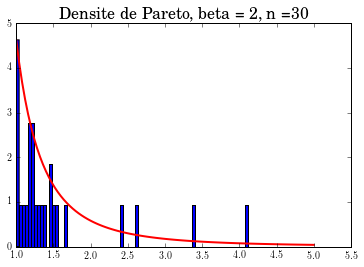

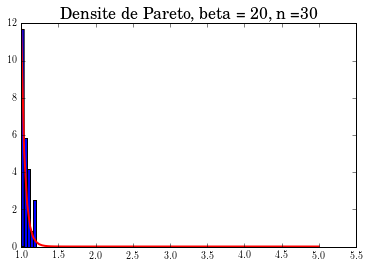

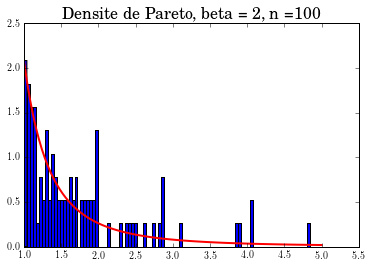

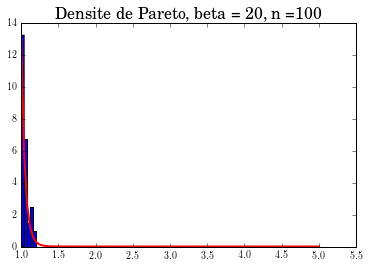

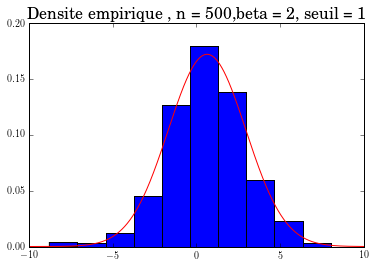

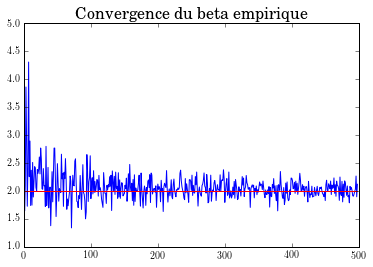

In [159]:
beta = 2
seuil = 1
n = 30
echantillon = funk_pareto(2,30,seuil,plot_boolean=True)
echantillon = funk_pareto(20,30,seuil,plot_boolean=True)
echantillon = funk_pareto(2,100,seuil,plot_boolean=True)
echantillon = funk_pareto(20,100,seuil,plot_boolean=True)

l=[]
a=2
g_tetha = (seuil/a)**beta
for esc in range(1,500):
    echantillon = funk_pareto(beta,100,seuil)
    l.append(np.sqrt(100)*((funk_beta_moment(echantillon,seuil))-beta))
l_sig=np.sqrt(np.var(l))
l_mean=np.mean(l)
lena = np.arange(-10,10,1/len(l))
norma = [(1/np.sqrt(2*np.pi*l_sig**2)*np.exp((-1/2)* ((x-l_mean)/l_sig)**2)) for x in lena]
plt.figure()
plt.hist(l,normed=True)
plt.plot(lena,norma,color="r")
plt.title("Densite empirique , n = 500,beta = 2, seuil = 1",fontsize=16)
plt.savefig("plot\\Converg1e_pareto_n=500_beta=2_c=1.png")

l_beta=[]
a=2
g_tetha = (seuil/a)**beta
for esc in range(1,500):
    echantillon = funk_pareto(beta,esc,seuil)
    l_beta.append((funk_beta_moment(echantillon,seuil)))
plt.figure()
plt.plot(l_beta)
plt.plot(np.repeat(2,len(l_beta)),'r')
plt.title("Convergence du beta empirique",fontsize=16)
plt.savefig("plot/Convergence_beta2.png")

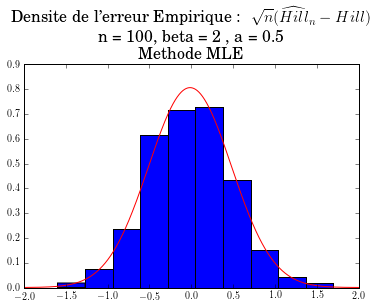

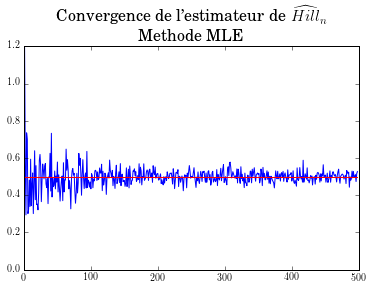

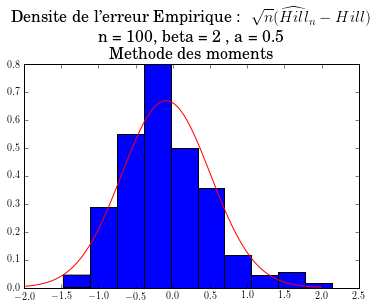

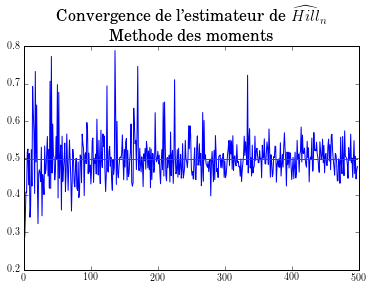

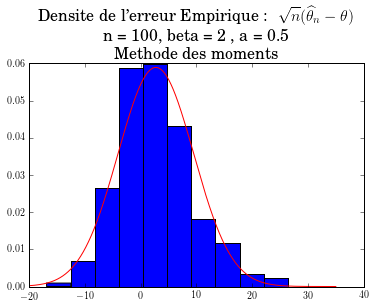

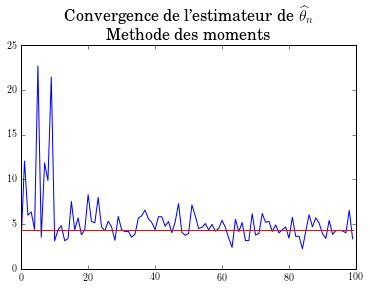

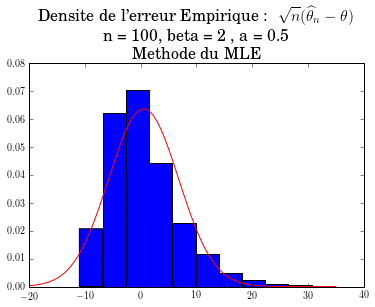

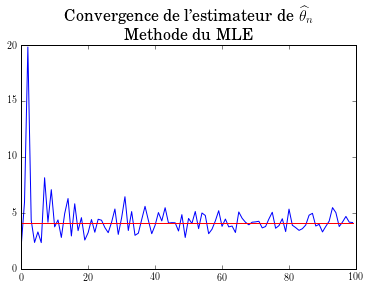

In [164]:
#Expperimental part
beta = 2
seuil = 1
a_i=.5
funk_test_graph_hill(beta, seuil,100,500 ,funk_hill_mle,a_i,"Methode MLE",plot_save=False)
funk_test_graph_hill(beta, seuil,100,500 ,funk_hill_moment,a_i,"Methode des moments",plot_save=False)

#Expperimental part
beta = 2
seuil = 1
a_i=.5
funk_test_graph_theta(beta, seuil,100,500 ,funk_theta_moment,a_i,"Methode des moments",plot_save=False)
funk_test_graph_theta(beta, seuil,100,500 ,funk_theta_mle,a_i,"Methode du MLE",plot_save=False)

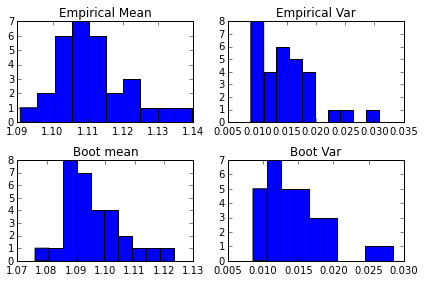

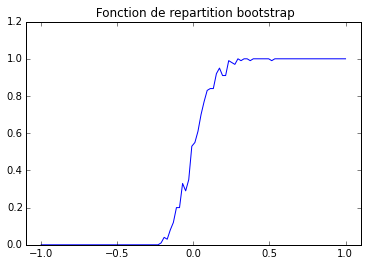

1.0

In [59]:
beta = 10 
seuil = 1
B = 70
n = 100
echantillon = funk_pareto(beta,n,seuil,plot_boolean=False)
l = funk_asymptot_naiv(beta,seuil,B,n)

m = np.round(n/5)
n = 30
beta = 10 
seuil = 1
echantillon = funk_pareto(beta,n,seuil)
mean_emp = funk_empirical_mean(echantillon)
funk_boot_strap_dist(echantillon,1,100,funk_empirical_mean,plot_call=True)

### Estimateur centré et réduit

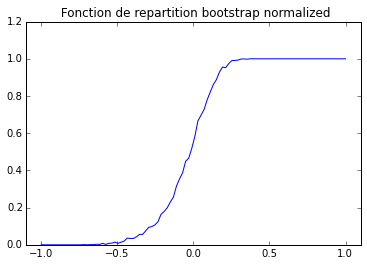

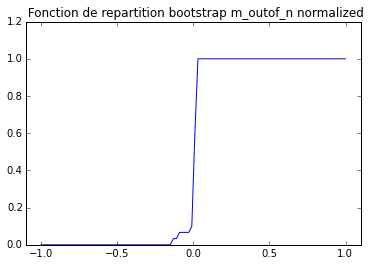

1.0

In [108]:

m = np.round(n/5)
n = 30
beta = 10 
seuil = 1
echantillon = funk_pareto(beta,n,seuil)
mean_emp = funk_empirical_mean(echantillon)
funk_boot_strap_dist_normalized(echantillon,0.5,funk_empirical_variance,1000,plot_call=True)
funk_bootstrap_outof_dist_normalized(echantillon,29,funk_empirical_variance,0.1,plot_call=True)

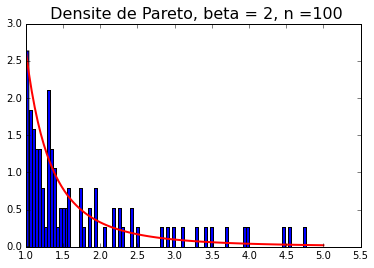

In [341]:
beta = 2
seuil = 1
B = 200
n = 100
echantillon = funk_pareto(beta,n,seuil,plot_boolean=True)

In [471]:
beta = 2
seuil = 1
n = 1000  ## il marche bien pour cette valeur
echantillon = funk_pareto(beta,n,seuil,plot_boolean=False)

def funk_bootstrap_outof_beta(ech,m,seuil,estimateur):
    # Fonction bootstrapant "m out of n" pour un estimateur
    #ech : array of float, m: int
    n = len(ech)
    thresh = funk_denomb(n,m)
    if(thresh< 5000000):
        s = set(ech)
        test = map(list, itertools.combinations(s, m))
        return(np.sum([estimateur(x,seuil) for x in test])*(1/len(test)))        
    else:
        print("Denombrement trop large")
print funk_bootstrap_outof_beta(echantillon,len(echantillon)-1,seuil,funk_beta_moment)
print funk_bootstrap_outof_beta(echantillon,len(echantillon)-1,seuil,funk_beta_mle_test)

2.01752564098
2.07469676641


### Estimation de beta par bootstrap

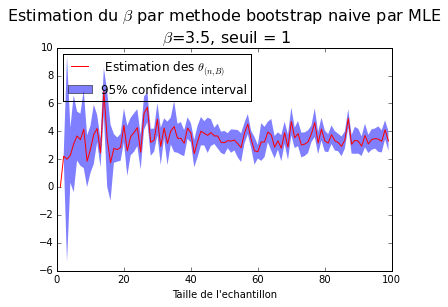

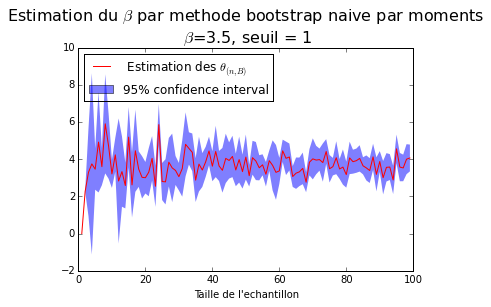

In [649]:
beta = 3.5
seuil = 1
a_i = 2
l=[]
n=100
test_mle = funk_graph_boot_naive_beta(beta,seuil,n,funk_beta_mle,'MLE')
test_mm = test = funk_graph_boot_naive_beta(beta,seuil,n,funk_beta_moment,'moments')

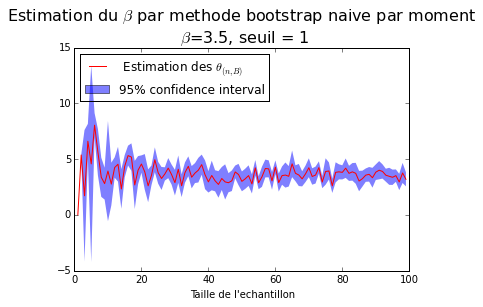

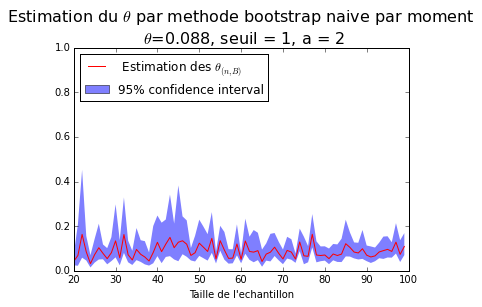

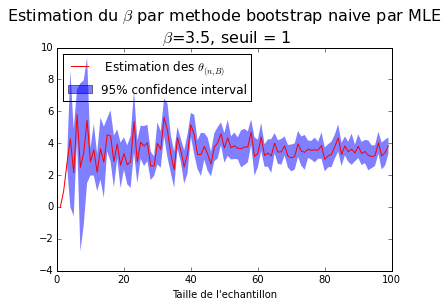

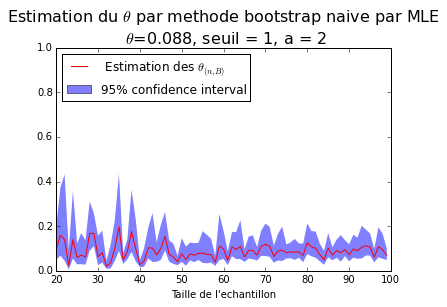

In [712]:
def funk_graph_boot_naive_theta(beta,seuil,a_i ,n,estimateur,type_name, dalloz=False):
    # graph de convergence pour le theta 
    # beta : float, seuil : float, n : integer, plot_save : Boolean
    l=[]
    x_r = range(1,n)
    test = funk_graph_boot_naive_beta(beta,seuil,n,estimateur,type_name)
    l = [(seuil/a_i)**x for x in test[0]]
    l_inf = [(seuil/a_i)**x for x in test[1]]
    l_sup =[(seuil/a_i)**x for x in test[2]]
    x_r= range(1,100)
    plt.figure()
    plt.title(r'Estimation du $\theta$ par methode bootstrap naive par '+type_name+ 
              '\n'+r' $\theta$='+str(np.round((seuil/a_i)**beta,3))+', seuil = '+str(seuil)+", a = "+str(a_i),fontsize=16)
    plt.plot(x_r, l, 'r', label=r' Estimation des $\theta_{(n,B)}$')
    plt.fill(np.concatenate([range(1,100), range(1,100)[::-1]]), \
            np.concatenate([l_inf,l_sup[::-1]]), \
            alpha=.5, fc='b', ec='None', label='95% confidence interval')
    plt.xlabel('Taille de l\'echantillon')
    plt.xlim(20,100)
    plt.ylim(0,1)
    plt.legend(loc='upper left')
    if(dalloz == True):
        plt.savefig("plot\\conv_theta_boot_naive_"+type_name+".png",bbox_inches="tight")
    plt.show()
    return([l,l_inf,l_sup])
   
beta = 3.5
seuil = 1
a_i = 2
l=[]
n=100 
type_name1= "moment"
test_mm = funk_graph_boot_naive_theta(beta,seuil,a_i ,n,funk_beta_moment,type_name1, dalloz=True)
type_name1= "MLE"
test_mle = funk_graph_boot_naive_theta(beta, seuil,a_i ,n,funk_beta_mle,type_name1, dalloz=True)

In [715]:
print 'vraie valeur'
print (seuil/a_i)**beta
print '\n pour n=30'
print str(np.round(test_mm[0][29],3)) + ' ['+ str(np.round(test_mm[1][29],3))+";"+ str(np.round(test_mm[2][29],3))+ ']'
print str(np.round(test_mle[0][29],3)) + ' ['+ str(np.round(test_mle[1][29],3))+";"+ str(np.round(test_mle[2][29],3))+ ']'
print '\n pour n=100'
print str(np.round(test_mm[0][98],3)) + ' ['+ str(np.round(test_mm[1][98],3))+";"+ str(np.round(test_mm[2][98],3))+ ']'
print str(np.round(test_mle[0][98],3)) + ' ['+ str(np.round(test_mle[1][98],3))+";"+ str(np.round(test_mle[2][98],3))+ ']'

vraie valeur
0.0883883476483

 pour n=30
0.134 [0.298;0.06]
0.063 [0.157;0.025]

 pour n=100
0.109 [0.169;0.07]
0.07 [0.099;0.049]


vraie valeur
0.0883883476483

 pour n=30
0.065 [-0.109;0.286]
0.103 [-0.15;0.327]

 pour n=100
0.08 [-0.012;0.189]
0.078 [-0.018;0.195]


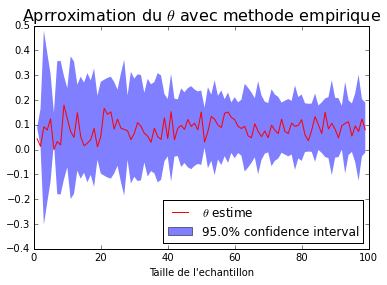

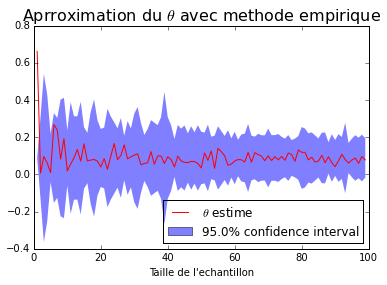

In [635]:
beta = 3.5
seuil = 1
a_i = 2
n=100
perce=0.95
test_mm =funk_theta_graph_conv(beta,seuil,a_i,n,perce,funk_theta_moment,'momment')
test_mle =funk_theta_graph_conv(beta,seuil,a_i,n,perce,funk_theta_mle,'MLE')
echantillon = funk_pareto(beta,n,seuil,plot_boolean=False)
print 'vraie valeur'
print (seuil/a_i)**beta
print '\n pour n=30'
print str(np.round(test_mm[0][29],3)) + ' ['+ str(np.round(test_mm[1][29],3))+";"+ str(np.round(test_mm[2][29],3))+ ']'
print str(np.round(test_mle[0][29],3)) + ' ['+ str(np.round(test_mle[1][29],3))+";"+ str(np.round(test_mle[2][29],3))+ ']'
print '\n pour n=100'
print str(np.round(test_mm[0][98],3)) + ' ['+ str(np.round(test_mm[1][98],3))+";"+ str(np.round(test_mm[2][98],3))+ ']'
print str(np.round(test_mle[0][98],3)) + ' ['+ str(np.round(test_mle[1][98],3))+";"+ str(np.round(test_mle[2][98],3))+ ']'

### Estimation du $\theta$ par bootstrap non-paramétrique

In [746]:
beta = 2
seuil = 1
a_i = 4
n = 20  ## il marche bien pour cette valeur
echantillon = funk_pareto(beta,n,seuil,plot_boolean=False)

In [744]:
l=[]
B=100
m = len(ech)
for esc in range(B):
        l.append(estimateur(funk_sample(ech,m,len(ech))))
    res = np.sum([1 if (np.sqrt(m)*(x - mean_emp) < thresh) else 0 for x in l])/B
np.sum([1 if (x < a_i) else 0 for x in l])/B

IndentationError: unindent does not match any outer indentation level (<ipython-input-744-fb1d56a2d436>, line 6)

In [738]:
def funk_theta_npemp(ech,a_i):
    # proba empirique de seuil
    # ech : array of floats, a_i : float
    res = [1 if x <a_i else 0 for x in ech]
    return(np.sum(res)/len(res))
def funk_theta_npbootnaiv(ech,a_i,B):
    # proba empirique de seuil
    # ech : array of floats, a_i : float
    l=[]
    for esc in range(B):
        l.append(funk_theta_npemp(funk_sample(ech,len(ech)),a_i))
    return(np.sum(l)/len(l))

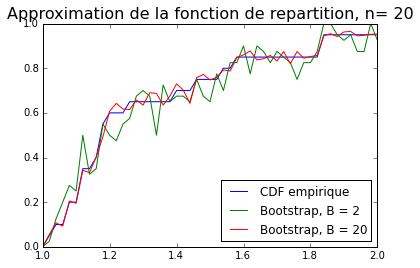

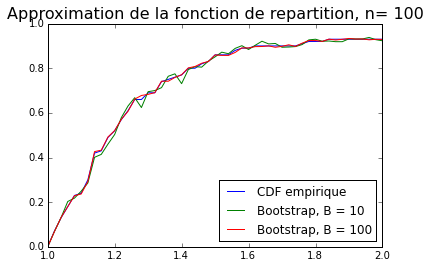

In [885]:
def funk_dist_boost_naiv(beta, seuil ,a_i,n,n_len,plot_save=False):
    # Afiche les estimations de la CDF empirique et bootstrap
    #beta,seuil,a_i : float, n,n_len : int , plot_save : Boolean
    echantillon = funk_pareto(beta,n,seuil,plot_boolean=False)
    sig = np.sqrt(np.var(echantillon))
    B = n
    plt.title("Approximation de la fonction de repartition, n= "+str(n),fontsize=16)
    x_r = [x*(1/50) for x in range(0,n_len)]
    l_emp = [funk_theta_npemp(echantillon,y) for y in [x*(1/50) for x in range(0,n_len)]]
    l_B = [funk_theta_npbootnaiv(echantillon,y,B) for y in [x*(1/50) for x in range(0,n_len)]]
    l_B10= [funk_theta_npbootnaiv(echantillon,y,int(np.round(B/10)) )
                                                for y in [x*(1/50) for x in range(0,n_len)]]
    #plt.figure()
    plt.plot(x_r, l_emp, label="CDF empirique")
    plt.plot(x_r,l_B10, label ="Bootstrap, B = " +str(int(B/10)))
    plt.plot(x_r,l_B, label ="Bootstrap, B = " +str(B))
    plt.xlim(1,2)
    plt.legend(loc='lower right')
    if(plot_save==True):
             plt.savefig('plot\dist_emp_n'+str(n)+'B'+str(B)+'.png',bbox_inches="tight")
    plt.show()
    return([x_r,l_emp,l_B,sig])

beta = 3.5
seuil = 1
a_i = 4
n_len= 200

test_n30 = funk_dist_boost_naiv(beta, seuil ,a_i,20,n_len)
test_n100 = funk_dist_boost_naiv(beta, seuil ,a_i,100,n_len)


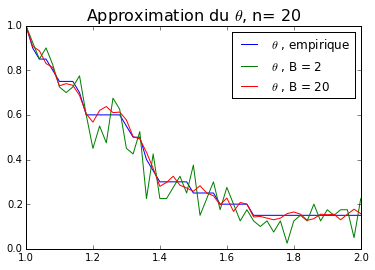

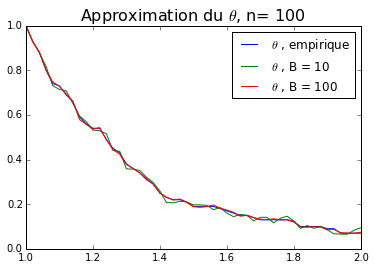

In [906]:
def funk_dist_boost_naiv_theta(beta, seuil ,a_i,n,n_len,plot_save=False):
    # Afiche les estimations de la CDF empirique et bootstrap
    #beta,seuil,a_i : float, n,n_len : int , plot_save : Boolean
    echantillon = funk_pareto(beta,n,seuil,plot_boolean=False)
    B = n
    plt.title(r"Approximation du $\theta$, n= "+str(n),fontsize=16)
    x_r = [x*(1/50) for x in range(0,n_len)]
    l_emp = [1-funk_theta_npemp(echantillon,y) for y in [x*(1/50) for x in range(0,n_len)]]
    l_B = [1-funk_theta_npbootnaiv(echantillon,y,B) for y in [x*(1/50) for x in range(0,n_len)]]
    l_B10= [1-funk_theta_npbootnaiv(echantillon,y,int(np.round(B/10)) )
                                                for y in [x*(1/50) for x in range(0,n_len)]]
    #plt.figure()
    plt.plot(x_r, l_emp, label=r'$\theta$ , empirique')
    plt.plot(x_r, l_B10, label =r'$\theta$ , B = ' +str(int(B/10)))
    plt.plot(x_r, l_B, label =r'$\theta$ , B = ' +str(B))
    plt.xlim(1,2)
    plt.legend(loc='upper right')
    if(plot_save==True):
             plt.savefig('plot\dist_emp_n'+str(n)+'B'+str(B)+'.png',bbox_inches="tight")
    plt.show()
    return([x_r,l_emp,l_B,echantillon])
beta = 3.5
seuil = 1
a_i = 4
n_len= 200

test_n30 = funk_dist_boost_naiv_theta(beta, seuil ,a_i,20,n_len)
test_n100 = funk_dist_boost_naiv_theta(beta, seuil ,a_i,100,n_len)

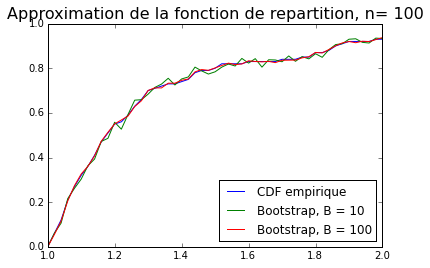

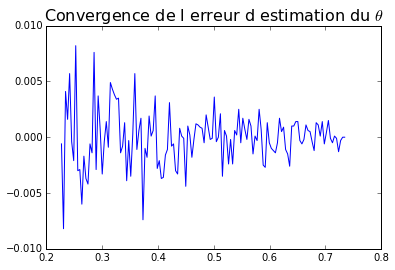

In [944]:
beta = 3.5
seuil = 1
a_i = 4
n_len= 200

#test_n30 = funk_dist_boost_naiv(beta, seuil ,a_i,20,n_len)
test_n100 = funk_dist_boost_naiv(beta, seuil ,a_i,100,n_len)
[ran1,emp,boot,sig] = test_n100

ranran = []
for esc in ran1:
    ranran.append(esc*(1/np.sqrt(n)) + (seuil/a_i)**beta)
plt.plot(ranran[60:],np.matrix(test_n100[0:3]).T [60:,1] - np.matrix(test_n100[0:3]).T [60:,2])
plt.title(r'Convergence de l erreur d estimation du $\theta$',fontsize=16)
plt.savefig("plot\error_conv_theta_np.png",bbox_inches="tight")

(0.2, 1)

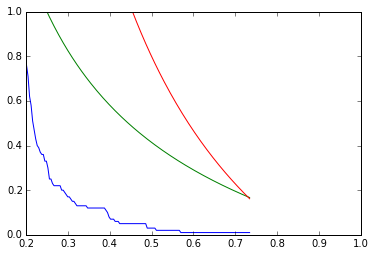

In [901]:
plt.plot(ranran,1-np.matrix(test_n100[0:3]).T [:,1])
plt.plot(ranran,[1/np.sqrt(x)-1 for x in ranran])
plt.plot(ranran,[1/x-1.2 for x in ranran])
plt.ylim(0,1)
plt.xlim(0.2,1)

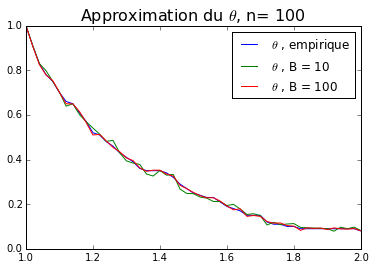

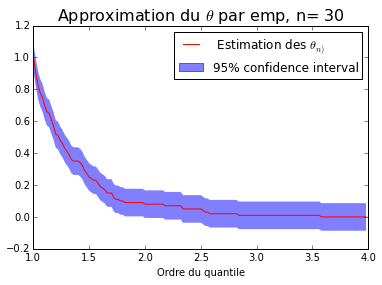

In [931]:
beta = 3.5
seuil = 1
a_i = 4
n_len= 200
type_name="emp"
test_n100 = funk_dist_boost_naiv_theta(beta, seuil ,a_i,100,n_len)
[x_r,l_emp,l_B,ech] = test_n100
test1 = ([l_emp[x] - 1.96*np.sqrt(np.var(ech))*(1/np.sqrt(len(ech))) for x in range(len(l_emp))]) # il faudra mettre les var de la loie normale
test2 = ([l_emp[x] + 1.96*np.sqrt(np.var(ech))*(1/np.sqrt(len(ech))) for x in range(len(l_emp))])
plt.figure()
plt.title(r'Approximation du $\theta$ par '+type_name+', n= '+str(n),fontsize=16)
plt.plot(x_r, l_emp, 'r', label=r' Estimation des $\theta_{n)}$')
plt.fill(np.concatenate([x_r, x_r[::-1]]), \
        np.concatenate([test1,test2[::-1]]), \
        alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('Ordre du quantile')
plt.xlim(seuil,seuil+3)
plt.legend(loc='upper right')

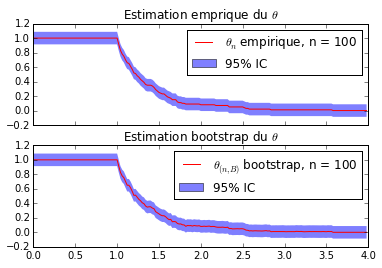

In [939]:
f, ((ax1, ax2)) = plt.subplots(2, 1, sharex='col', sharey='row')
test1 = ([l_emp[x] - 1.96*np.sqrt(np.var(ech))*(1/np.sqrt(len(ech))) for x in range(len(l_emp))]) # il faudra mettre les var de la loie normale
test2 = ([l_emp[x] + 1.96*np.sqrt(np.var(ech))*(1/np.sqrt(len(ech))) for x in range(len(l_emp))])
ax1.set_title(r'Estimation emprique du $\theta$')
ax1.plot(x_r, l_emp, 'r', label=r'$\theta_{n}$ empirique, n = '+str(len(ech)))
ax1.fill(np.concatenate([x_r, x_r[::-1]]), \
        np.concatenate([test1,test2[::-1]]), \
        alpha=.5, fc='b', ec='None', label='95% IC')
ax1.legend(loc='upper right')
test1 = ([l_B[x] - 1.96*np.sqrt(np.var(ech))*(1/np.sqrt(len(ech))) for x in range(len(l_B))]) # il faudra mettre les var de la loie normale
test2 = ([l_B[x] + 1.96*np.sqrt(np.var(ech))*(1/np.sqrt(len(ech))) for x in range(len(l_B))])
ax2.set_title(r'Estimation bootstrap du $\theta$')
ax2.plot(x_r, l_B, 'r', label=r'$\theta_{(n,B)}$ bootstrap, n = '+str(len(ech)))
ax2.fill(np.concatenate([x_r, x_r[::-1]]), \
        np.concatenate([test1,test2[::-1]]), \
        alpha=.5, fc='b', ec='None', label='95% IC')
ax2.legend(loc='upper right')
f.savefig("plot\\theta_boot_np_n100.png",bbox_inches="tight")

In [ ]:

plt.figure()
plt.title(r'Approximation du $\theta$ par '+type_name+', n= '+str(n),fontsize=16)
plt.plot(x_r, l_emp, 'r', label=r' Estimation des $\theta_{(n,B)}$')
plt.fill(np.concatenate([x_r, x_r[::-1]]), \
        np.concatenate([test1,test2[::-1]]), \
        alpha=.5, fc='b', ec='None', label='95% confidence interval')